# Energy Prediction

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import norm, boxcox
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [3]:
data = pd.read_excel('energy_consump.xlsx', parse_dates=[['Date', 'Time']])

In [4]:
data.head()

,Date_Time,Temperature (°C),Humidity (%),Energy Consumption (kWh)
0,2022-01-01 00:00:00,20.3,45,2.3
1,2022-01-01 01:00:00,19.8,46,2.5
2,2022-01-01 02:00:00,19.5,47,2.7
3,2022-01-01 03:00:00,19.3,47,2.9
4,2022-01-01 04:00:00,19.1,48,3.1


In [5]:
# set index
data.set_index('Date_Time', inplace=True)

In [6]:
data.head()

,Temperature (°C),Humidity (%),Energy Consumption (kWh)
Date_Time,,,
2022-01-01 00:00:00,20.3,45,2.3
2022-01-01 01:00:00,19.8,46,2.5
2022-01-01 02:00:00,19.5,47,2.7
2022-01-01 03:00:00,19.3,47,2.9
2022-01-01 04:00:00,19.1,48,3.1


# EDA

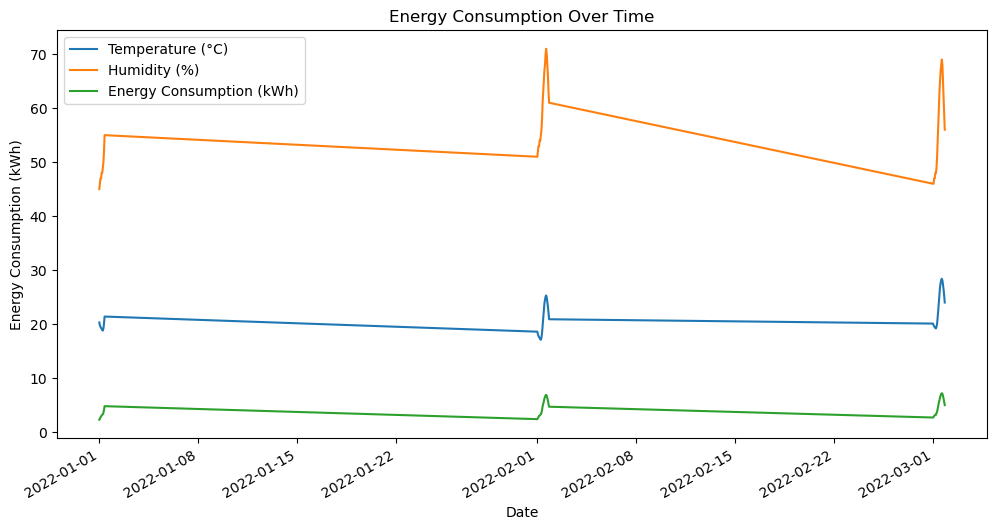

In [7]:
# plotting all the attributes
data.plot(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Over Time')
plt.show()


In [8]:
# calculate descriptive statistics
print(data.describe())

       Temperature (°C)  Humidity (%)  Energy Consumption (kWh)
count         52.000000     52.000000                 52.000000
mean          21.651923     56.942308                  4.526923
std            3.342389      8.180353                  1.581153
min           17.100000     45.000000                  2.300000
25%           19.200000     49.000000                  3.100000
50%           20.200000     55.500000                  4.200000
75%           24.200000     65.000000                  5.975000
max           28.400000     71.000000                  7.200000


In [9]:
# check for missing values
print(data.isna().sum())

Temperature (°C)            0
Humidity (%)                0
Energy Consumption (kWh)    0
dtype: int64


# Visualization Time Series Analysis

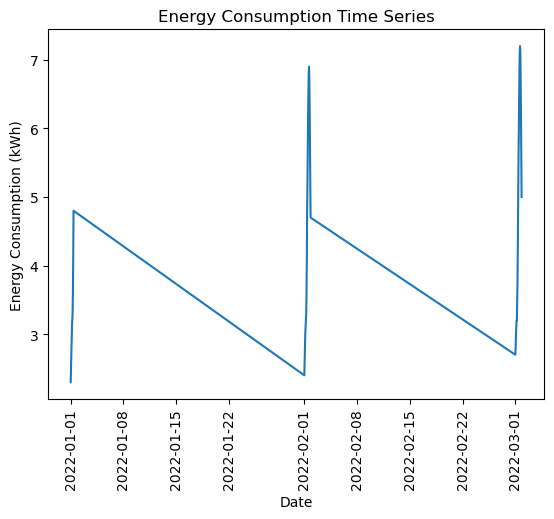

In [10]:
plt.plot(data.index, data['Energy Consumption (kWh)'])
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Time Series')
plt.show()


# Decompose Time Series Analysis

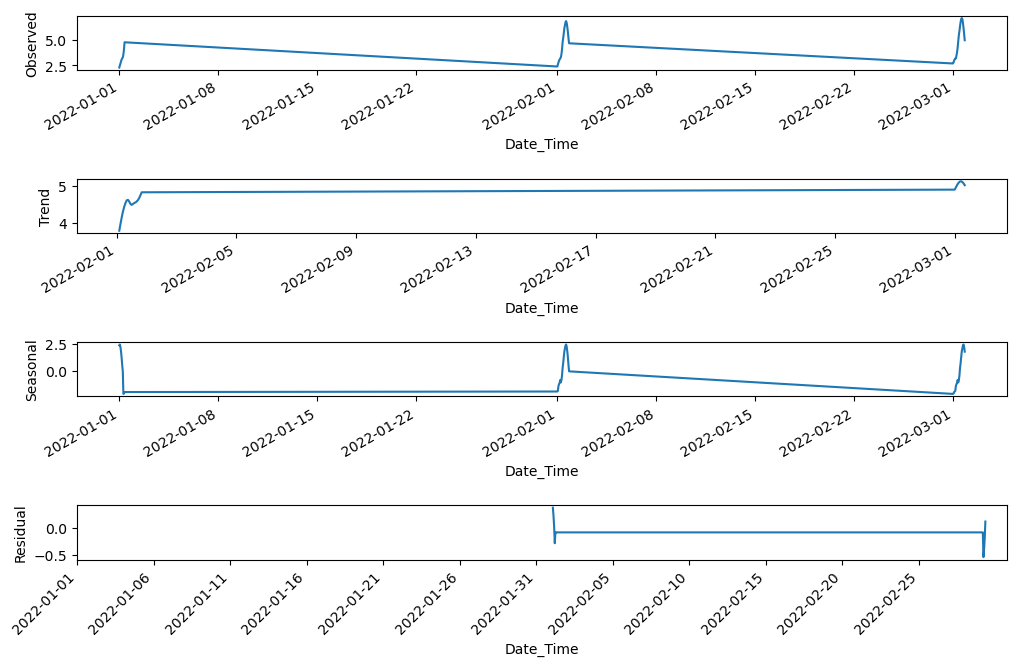

In [11]:
result = seasonal_decompose(data['Energy Consumption (kWh)'], model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(12, 8))
result.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')

# Set x-tick labels to every 5th day
xticks = pd.date_range(data.index.min(), data.index.max(), freq='5D')
xticklabels = [x.strftime('%Y-%m-%d') for x in xticks]
axes[3].set_xticks(xticks)
axes[3].set_xticklabels(xticklabels, rotation=45, ha='right')
fig.subplots_adjust(hspace=2)
plt.show()

# Relationship B/W Target and Attributes

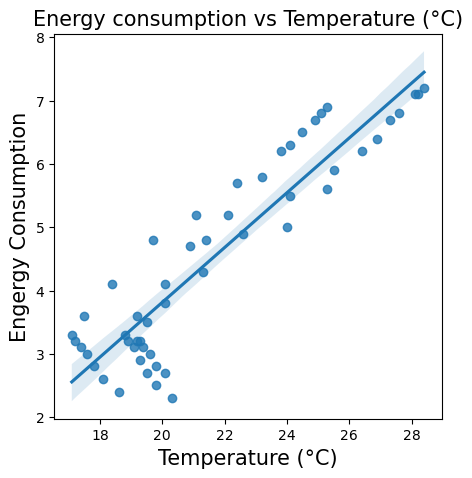

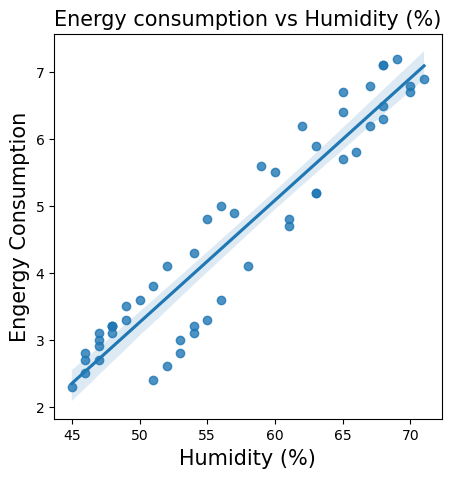

In [12]:
def bivariate_analysis(x):
    plt.figure(figsize=(5,5))
    ax=sns.regplot(x=x,y='Energy Consumption (kWh)',data=data)
    ax.set_title("Energy consumption vs "+x,fontsize=15)
    ax.set_xlabel(x,fontsize=15)
    ax.set_ylabel('Engergy Consumption',fontsize=15)
    plt.locator_params(axis='both')
    
for i in ['Temperature (°C)','Humidity (%)']:
    bivariate_analysis(i)

# Correlation

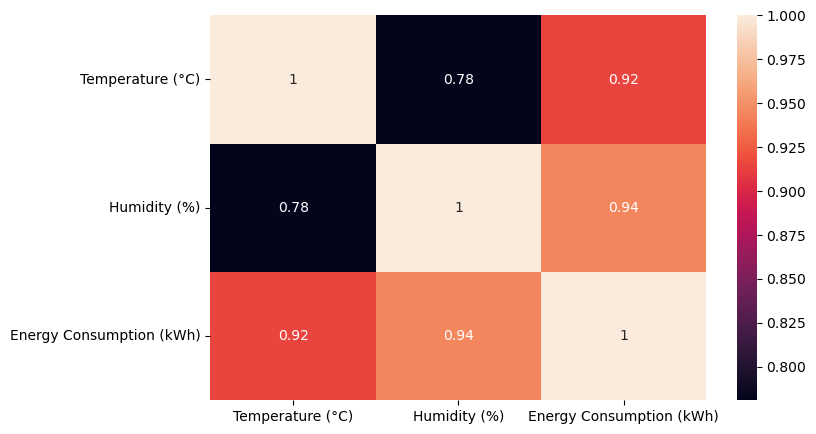

In [13]:
fig = plt.figure(figsize=(8,5))
sns.heatmap(data.corr(),annot=True)
plt.show()

# Checking Outliers

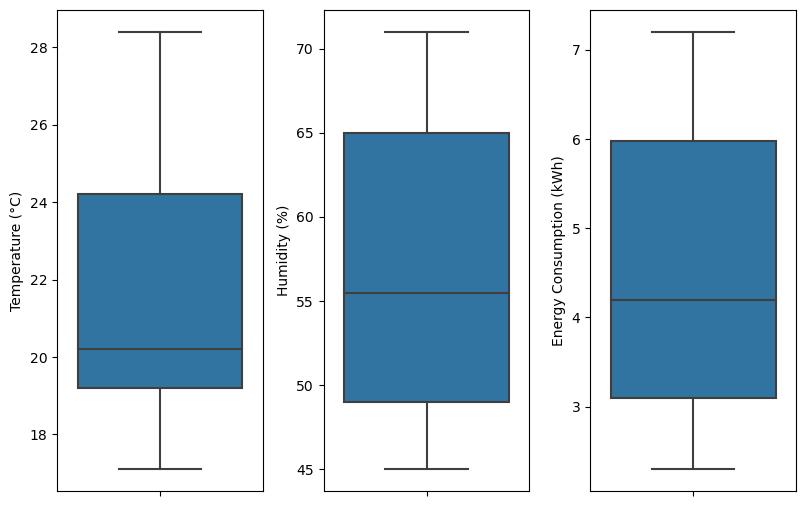

In [14]:
fig,ax=plt.subplots(1,3,figsize=(8,5))
index=0
ax=ax.flatten()
for col in data.columns:
    sns.boxplot(y=col,data=data,ax=ax[index])
    index+=1
plt.tight_layout(pad=0.5, w_pad=1, h_pad=5.0)

__No Outliers Detected__

# Checking Skewness 

In [15]:
def check_skweness(columnName):
    (mu, sigma) = norm.fit(data[columnName])
    print("Mean {} : {}, Sigma {} : {}".format(
        columnName.upper(), mu, columnName.upper(), sigma))
    plt.figure(figsize=(8,5))
    sns.distplot(data[columnName], fit=norm, color="orange")
    plt.title(columnName.upper() + "Distplot")
    plt.show();

Mean TEMPERATURE (°C) : 21.65192307692308, Sigma TEMPERATURE (°C) : 3.31009472236157


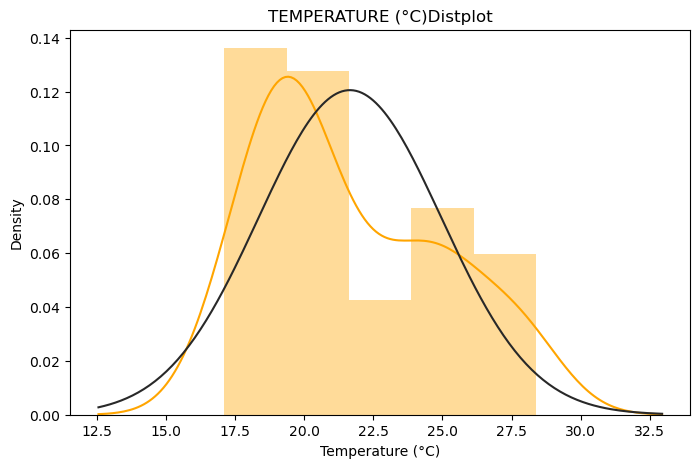

Mean HUMIDITY (%) : 56.94230769230769, Sigma HUMIDITY (%) : 8.10131390468537


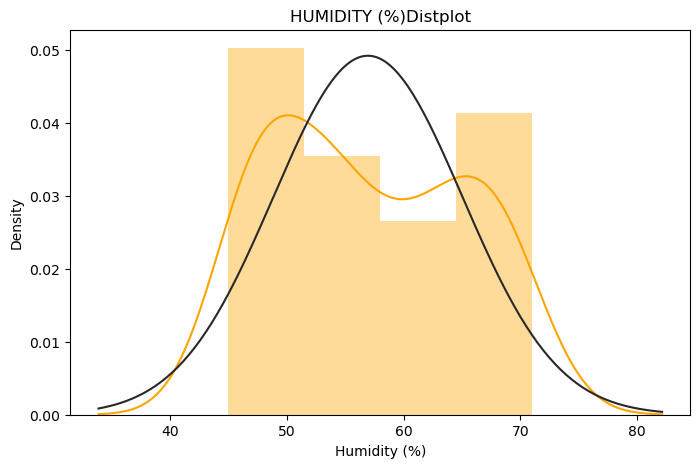

Mean ENERGY CONSUMPTION (KWH) : 4.526923076923077, Sigma ENERGY CONSUMPTION (KWH) : 1.5658759387707897


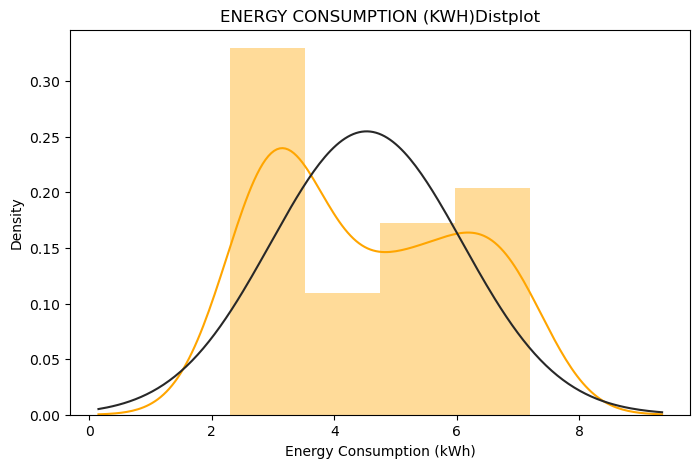

In [16]:
for columns in data.columns:
    check_skweness(columns)

# Training Model

In [17]:
# train model
model = ARIMA(data['Energy Consumption (kWh)'], order=(1, 0, 0)).fit()

# Predicting Unknown Values

In [18]:
new_data = pd.DataFrame({
    'Date_Time': pd.to_datetime(['2022-02-01 21:00:00']),
    'Temperature (°C)': [19.6],
    'Humidity (%)': [58]
})
new_data.set_index('Date_Time', inplace=True)
combined_data = pd.concat([data, new_data])
# predict energy consumption for given date and time
model_fit_new = ARIMA(combined_data['Energy Consumption (kWh)'], order=(1, 0, 0)).fit()
y_pred_new = model_fit_new.forecast(steps=1)
print('Predicted Energy Consumption:', y_pred_new)

Predicted Energy Consumption: 53    4.899797
dtype: float64


# Checking Accuracy 

In [24]:
#splitting dataset
train_data = data.iloc[:42]
test_data = data.iloc[42:]

In [25]:
# Fit ARIMA model on training set
model = ARIMA(train_data['Energy Consumption (kWh)'], order=(1, 0, 0))
model_fit = model.fit()

In [26]:
# Make predictions on testing set
y_pred = model_fit.forecast(steps=len(test_data))

In [27]:
# Calculate MAE, MSE, and RMSE
mae = np.mean(np.abs(y_pred.reset_index()['predicted_mean'] - test_data.reset_index()['Energy Consumption (kWh)']))
mse = np.mean(np.square(y_pred.reset_index()['predicted_mean'] - test_data.reset_index()['Energy Consumption (kWh)']))
rmse = np.sqrt(mse)


In [28]:
# Print accuracy metrics
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

MAE: 1.4664011542946622
MSE: 2.569330757977978
RMSE: 1.6029132097459233
